In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import sys
import itertools
import math
import pandas as pd
from PIL import Image, ImageDraw
import seaborn as sns
rng = np.random.default_rng()

In [93]:
import sampling_and_kin_functions as skf

In [94]:
# Making a map of Kibale
#kibale = Image.open("Kibale_outline.png")
#new_kibale = kibale.convert("L")
#new_kibale.save("kibale.png")

In [4]:
# All black image for testing
allzero = Image.new("L", (500, 500))
allzero.save("allzero.png")

### SLiM parameters I would want to change to generate the training data set

Output files: SPAT_SAMP_OUT, SAMPLE_LOCS_OUT, RAND_SAMP_OUT, POPSIZE_FILE

Population size: N0

Sampling times, minimum sample size per time, and potential locations: SAMPLE_YEARS, SAMPLE_DAYS, SAMPLE_SIZE

In [95]:
%%bash
slim -s 119 -d N0=1000 -d 'SAMPLE_YEARS=200' -d 'SAMPLE_DAYS=1' -d SAMPLE_SIZE=100 -d 'SPAT_SAMPLE_OUT="spatial_sample.csv"' -d 'SAMPLE_LOCS_OUT="spatial_sample_intensity.csv"' -d 'RAND_SAMP_OUT="random_sample.csv"' -d 'POPSIZE_FILE="popsize.csv"' elephants.slim

// Initial random seed:
119

// RunInitializeCallbacks():
initializeSLiMModelType(modelType = 'nonWF');
initializeSLiMOptions(keepPedigrees = T, dimensionality = 'xy');
initializeSex("A");
initializeInteractionType(1, "xy", reciprocal=T, maxDistance=0.5, sexSegregation="FM");
initializeInteractionType(2, "xy", reciprocal=T, maxDistance=0.5);
initializeInteractionType(3, "xy", reciprocal=T, maxDistance=0.2);
initializeMutationType(1, 0.5, "f", 0);
initializeGenomicElementType(1, m1, 1);
initializeGenomicElement(g1, 0, 99999);
initializeMutationRate(0);
initializeRecombinationRate(1e-08);

// Starting run at tick <start>:
1 



In [96]:
# Sampled individuals
spatial_sample = pd.read_csv("spatial_sample.csv")
random_sample = pd.read_csv("random_sample.csv")
# Population sizes
popsize = pd.read_csv("popsize.csv")
# Intensities
spatial_sample_intensity = pd.read_csv("spatial_sample_intensity.csv")

In [97]:
print(len(spatial_sample))
unique_inds = spatial_sample.drop_duplicates()
print(len(unique_inds))
print(len(random_sample))
unique_rand = random_sample.drop_duplicates()
print(len(unique_rand))

100
98
100
100


In [98]:
#sample_parents = unique_inds
sample_parents = unique_rand
# Find individuals in the sample that have a child in the sample
ind_in_p1 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent1'])
ind_in_p2 = np.isin(sample_parents.loc[:,'individual'].values, sample_parents.loc[:,'parent2'])

# Mothers and Fathers
mothers = sample_parents[ind_in_p1]
fathers = sample_parents[ind_in_p2]
mother_list = mothers.loc[:,'individual'].values
father_list = fathers.loc[:,'individual'].values

# Find the parents of children in the sample and how many children in the sample they have (the parents don't need to be in the sample)
# Mothers are parent1 and fathers are parent2
all_mothers, all_mother_counts = np.unique(sample_parents.loc[:,'parent1'].values, return_counts = True)
all_fathers, all_father_counts = np.unique(sample_parents.loc[:,'parent2'].values, return_counts = True)

# Find parents with multiple children in the sample (parents of siblings)
maternal_sib_parents = all_mothers[all_mother_counts > 1]
paternal_sib_parents = all_fathers[all_father_counts > 1]

# Record POPs and half-sibling pairs
maternal_pops = skf.find_POPs_or_sibs(mother_list, sample_parents, "PO")
paternal_pops = skf.find_POPs_or_sibs(father_list, sample_parents, "PO")
maternal_sibs = skf.find_POPs_or_sibs(maternal_sib_parents, sample_parents, "HS")
paternal_sibs = skf.find_POPs_or_sibs(paternal_sib_parents, sample_parents, "HS")

# Full sibling pairs appear in both maternal and paternal arrays
if np.any([x in paternal_sibs for x in maternal_sibs]):
    full_sibs = maternal_sibs[np.where([x in paternal_sibs for x in maternal_sibs])[0][0]]
else:
    full_sibs = []

# Plot maternal POPs, paternal POPs, and half-sibling pairs
w, h = 500, 500
max_width = 10
max_height = 10

pops_spaghetti = Image.new("1", (w, h))
img1 = ImageDraw.Draw(pops_spaghetti)
skf.draw_pairs(maternal_pops, img1, sample_parents, max_width, max_height, w, h)
skf.draw_pairs(paternal_pops, img1, sample_parents, max_width, max_height, w, h)

sibs_spaghetti = Image.new("1", (w, h))
img2 = ImageDraw.Draw(sibs_spaghetti)
skf.draw_pairs(maternal_sibs, img2, sample_parents, max_width, max_height, w, h)
skf.draw_pairs(paternal_sibs, img2, sample_parents, max_width, max_height, w, h)

# Number of parent offspring and HS pairs
npops = len(maternal_pops) + len(paternal_pops)
nsibs =  len(maternal_sibs) + len(paternal_sibs)

print("Number of parent offspring pairs: ", npops)
print("Number of half-sibling pairs: ", nsibs)
print("Number of full-sibling pairs: ", len(full_sibs))

Finding pairs
Finding pairs
Finding pairs
Finding pairs
Number of parent offspring pairs:  3
Number of half-sibling pairs:  32
Number of full-sibling pairs:  2


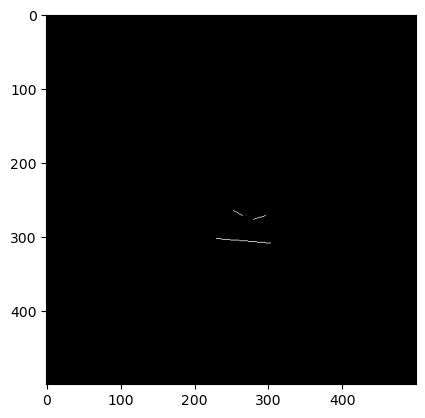

In [99]:
plt.imshow(pops_spaghetti)

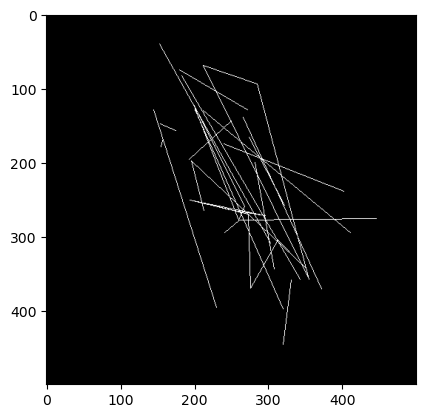

In [100]:
plt.imshow(sibs_spaghetti)

<Axes: xlabel='x', ylabel='y'>

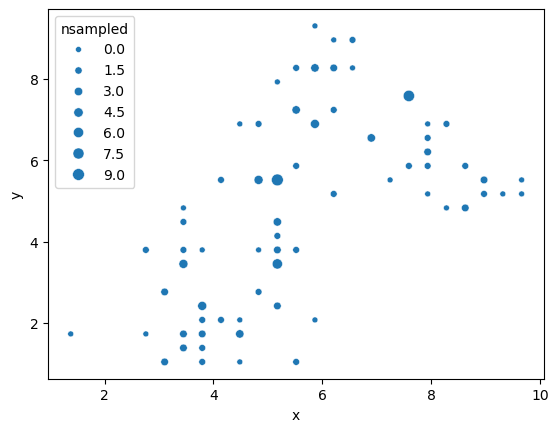

In [101]:
sns.scatterplot(spatial_sample_intensity, x='x', y='y', size = 'nsampled')


In [102]:
spatial_sample_intensity

,x,y,year,day,nsampled
0,7.58621,7.58621,200.0,1.0,8.0
1,7.58621,5.86207,200.0,1.0,1.0
2,3.79310,2.41379,200.0,1.0,4.0
3,7.93103,5.17241,200.0,1.0,0.0
4,5.86207,2.06897,200.0,1.0,0.0
...,...,...,...,...,...
62,4.48276,6.89655,200.0,1.0,0.0
63,2.75862,1.72414,200.0,1.0,0.0
64,6.20690,7.24138,200.0,1.0,1.0
65,4.82759,6.89655,200.0,1.0,1.0


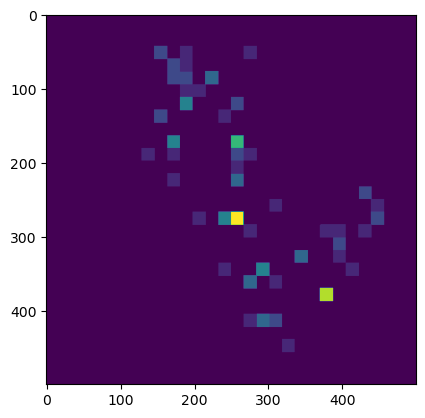

In [139]:
intensity = Image.new("L", (w, h))
img1 = ImageDraw.Draw(intensity)
xlist = spatial_sample_intensity.loc[:,'x'].values
ylist = spatial_sample_intensity.loc[:,'y'].values
fills = spatial_sample_intensity.loc[:,'nsampled'].values.astype(int)
dw = 1/3
dh = dw
maxfill = max(fills)
for i, fill in enumerate(fills):
    x0 = (xlist[i] - dw/2)*w/max_width
    y0 = (ylist[i] - dh/2)*h/max_height
    x1 = (xlist[i] + dw/2)*w/max_width
    y1 = (ylist[i] + dh/2)*h/max_height
    fill_n = int(255*fill/maxfill)
    img1.rectangle([x0, y0, x1, y1], fill = fill_n)
plt.imshow(intensity)
intensity.save("intensity_map.png")